In [1]:
using AlfvenDetectors
using PyPlot
using BSON
using Flux
using ValueHistories
using StatsBase
using Random

In [2]:
using PyCall
umap = pyimport("umap")

PyObject <module 'umap' from '/home/vit/anaconda3/lib/python3.7/site-packages/umap/__init__.py'>

In [3]:
# include the eval utilities code
adpath = dirname(dirname(pathof(AlfvenDetectors)))
include(joinpath(adpath, "experiments/eval_utils.jl"))

labeled_data

In [4]:
modelpath = "/home/vit/vyzkum/alfven/experiments/conv/uprobe/"

"/home/vit/vyzkum/alfven/experiments/conv/uprobe/"

In [88]:
mf = joinpath(modelpath, "batchnorm-test/ConvAE_xdim-(128, 128, 1)_ldim-64_nlayers-2_kernelsize-3_channels-[2, 4]_scaling-2_batchnorm-true_batchsize-128_nepochs-1000_opt-RMSProp_eta-0.001_usegpu-true_memoryefficient-true_2019-04-05T17:03:35.079.bson")
model_data = BSON.load(mf)
params = parse_params(mf)
hist = model_data[:history]
model = model_data[:model]
if get(params, :batchnorm, false)
    Flux.testmode!(model);
end
display(params)

Dict{Any,Any} with 15 entries:
  :channels        => [2, 4]
  :ldim            => 64
  :time            => "2019-04-05T17:03:35.079"
  :eta             => 0.001
  :nlayers         => 2
  :nepochs         => 1000
  :xdim            => (128, 128, 1)
  :kernelsize      => 3
  :scaling         => 2
  :batchnorm       => true
  :batchsize       => 128
  :opt             => RMSProp
  :usegpu          => true
  :memoryefficient => true
  :model           => "ConvAE"

In [89]:
datapath = "/home/vit/vyzkum/alfven/cdb_data/uprobe_data/"
labeled_shots, shot_labels = labeled_data()
Random.seed!(123)
iused = sample(1:size(labeled_shots,1), 10, replace=false)
labeled_shots = labeled_shots[iused]
shot_labels = shot_labels[iused]
datafiles = readdir(datapath);
println("$(length(datafiles)) shots available")

1028 shots available


In [7]:
patchsize = 128
readfun = AlfvenDetectors.readnormlogupsd
data_labels = []
data_shotnos = []
data = Array{Float32,4}(undef,patchsize,patchsize,1,0)
for (label, shot) in zip(shot_labels, labeled_shots)
    file = joinpath.(datapath, datafiles[map(x->occursin("$shot", x),datafiles)])
    X = AlfvenDetectors.collect_conv_signals(file, readfun, patchsize)
    N = size(X,4)
    data = cat(data,X,dims=4)
    push!(data_labels, fill(label,N))
    push!(data_shotnos, fill(shot,N))
end
data_labels = vcat(data_labels...);
data_shotnos = vcat(data_shotnos...);

In [10]:
GC.gc()

In [90]:
# now compute the code in batches
batchsize = 10
z = model.encoder(data[:,:,:,1:batchsize]).data;
for i in 2:floor(Int,size(data,4)/batchsize)
    z=cat(z, model.encoder(data[:,:,:,((i-1)*batchsize+1):i*batchsize]).data, dims=2)
end
z=cat(z, model.encoder(data[:,:,:,end-(size(data,4)%batchsize)+1:end]).data, dims=2);

In [91]:
umap_model = umap.UMAP(n_components = 2, n_neighbors=15, min_dist=0.1)

PyObject UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=False)

In [95]:
z2D = Array(umap_model.fit_transform(z')')

2×2024 Array{Float32,2}:
 8.64655  -9.23588  -11.2881   -10.3398   …  -8.08425  -8.23813  -10.1591 
 4.14574   4.60008    4.92796    5.86301      2.56307   2.60612    5.34494

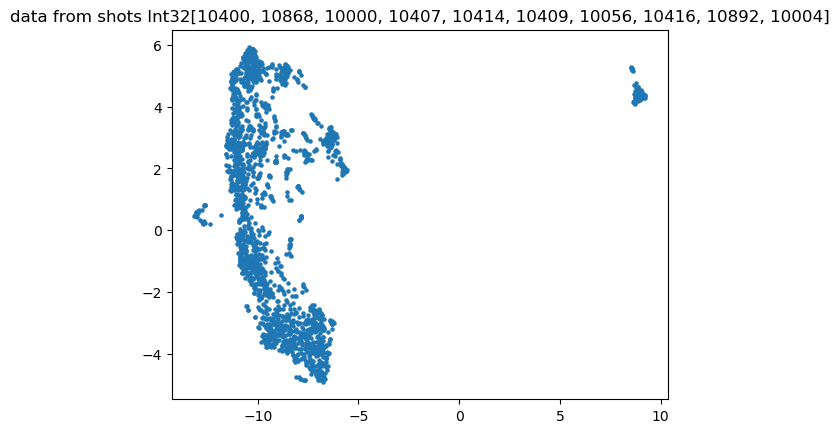

PyObject Text(0.5, 1.0, 'data from shots Int32[10400, 10868, 10000, 10407, 10414, 10409, 10056, 10416, 10892, 10004]')

In [96]:
scatter(z2D[1,:],z2D[2,:],s=5)
title("data from shots $(labeled_shots)")

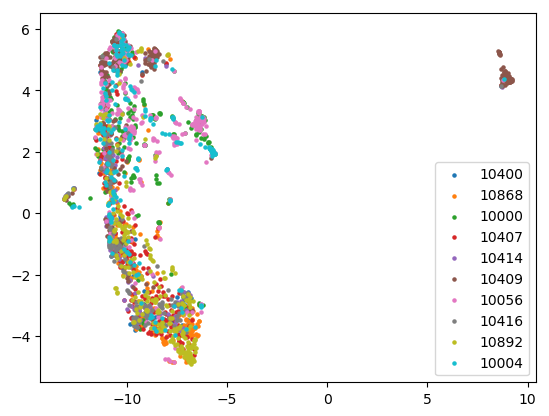

PyObject <matplotlib.legend.Legend object at 0x7f06f8abffd0>

In [97]:
for shotno in unique(data_shotnos)
    zs = z2D[:,data_shotnos.==shotno]
    scatter(zs[1,:], zs[2,:],s=5,label="$shotno")
end
legend()

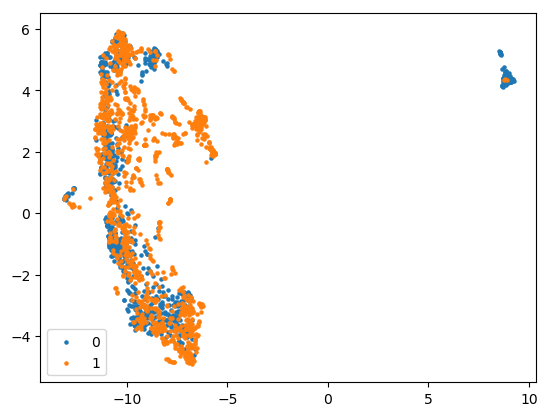

PyObject <matplotlib.legend.Legend object at 0x7f06f8a385f8>

In [98]:
for label in unique(data_labels)
    zs = z2D[:,data_labels.==label]
    scatter(zs[1,:], zs[2,:],s=5,label="$label")
end
legend()

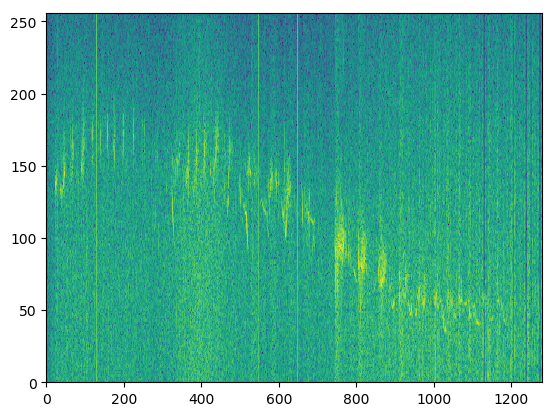

2×20 Array{Float32,2}:
 2.70814  1.97401  2.16441  2.31519  …  3.76272  1.84467  2.9168   1.95842
 3.22397  5.65482  3.38092  5.66795     3.46654  5.66846  4.00947  5.84433

In [63]:
testdata = readfun(joinpath(datapath, "uprobe_10893.h5"));
testdata = testdata[129:384, 1537:2816]
figure()
pcolormesh(testdata)
testdata = AlfvenDetectors.split_reshape(testdata,patchsize);
size(testdata)
testz = model.encoder(testdata).data;
testz2D = Array(umap_model.transform(testz')')

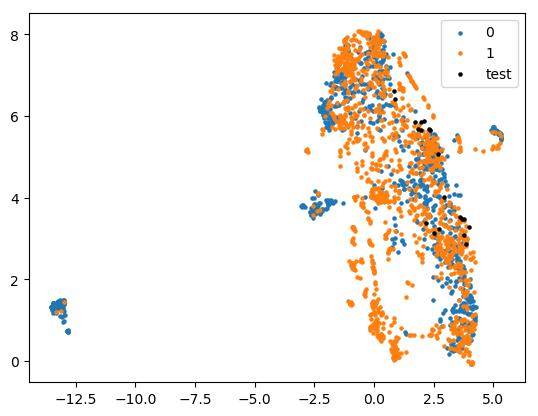

PyObject <matplotlib.legend.Legend object at 0x7f06fd22b828>

In [65]:
for label in unique(data_labels)
    zs = z2D[:,data_labels.==label]
    scatter(zs[1,:], zs[2,:],s=5,label="$label")
end
scatter(testz2D[1,:], testz2D[2,:],s=5,label="test",c="k")
legend()

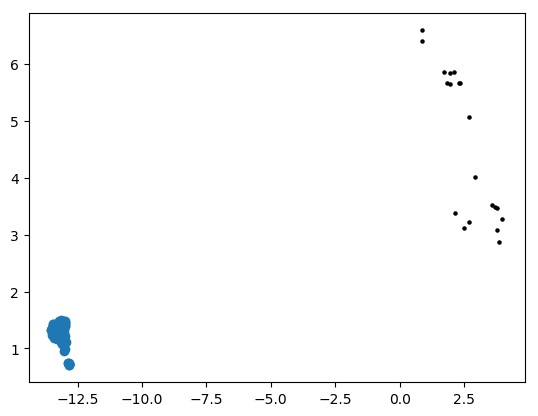

PyObject <matplotlib.collections.PathCollection object at 0x7f06f8c866a0>

In [81]:
clusterinds = collect(1:size(z2D,2))[ (-50. .< z2D[1,:] .< -10) .&  (-10 .< z2D[2,:] .< 10)]
#clusterinds = collect(1:size(z2D,2))[ (-2. .< z2D[1,:] .< 1) .&  (0 .< z2D[2,:] .< 3)]
#clusterinds = collect(1:size(z2D,2))[ (0.5 .< z2D[1,:] .< 3) .&  (5.5 .< z2D[2,:] .< 6.5)]
scatter(z2D[1,clusterinds],z2D[2,clusterinds])
scatter(testz2D[1,:], testz2D[2,:],s=5,label="test",c="k")


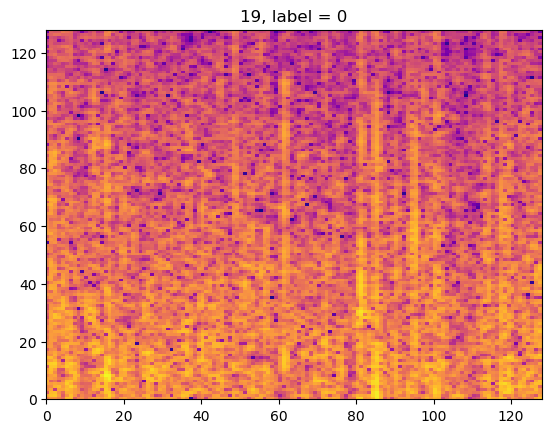

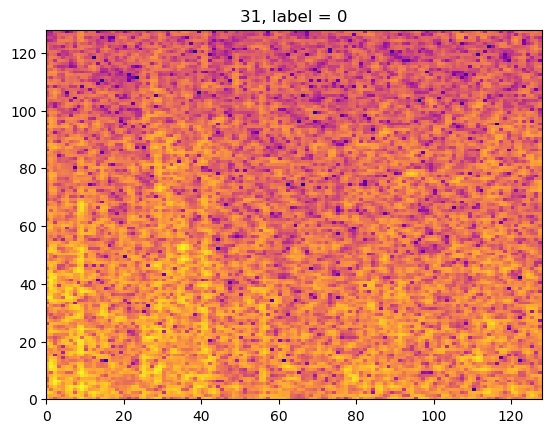

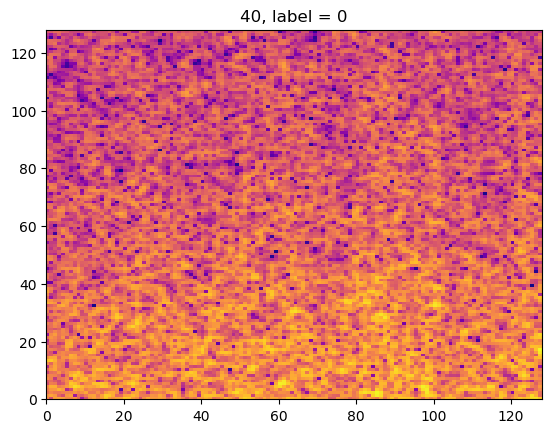

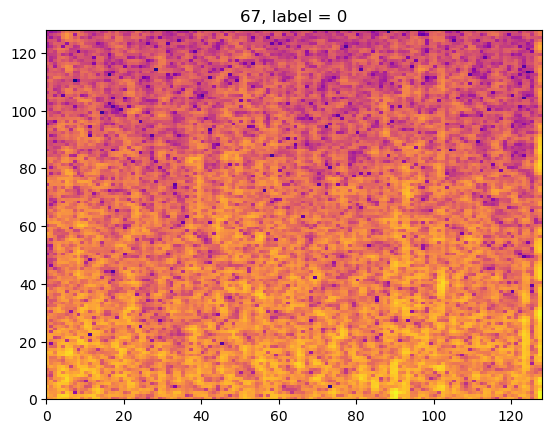

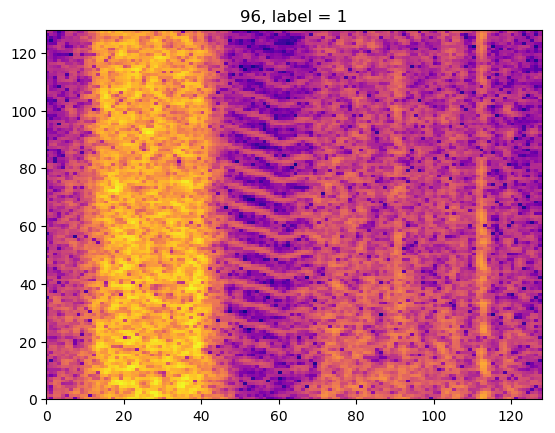

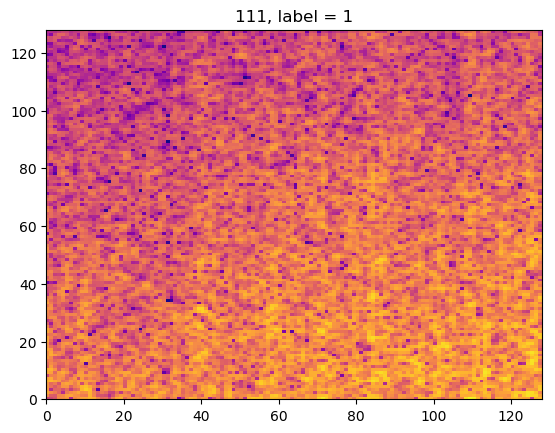

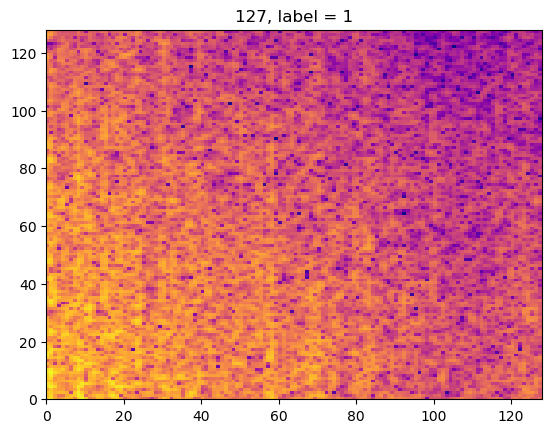

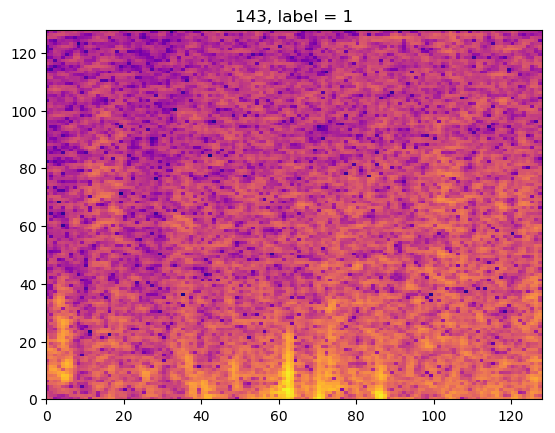

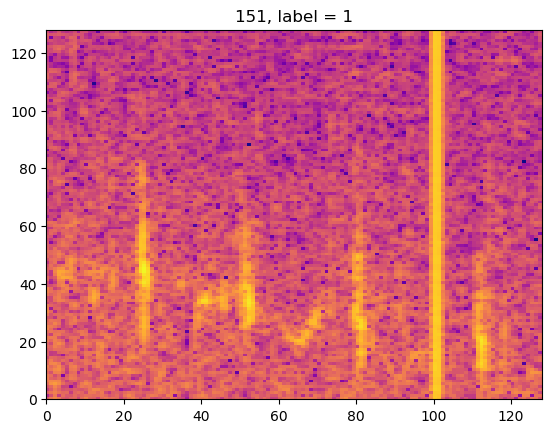

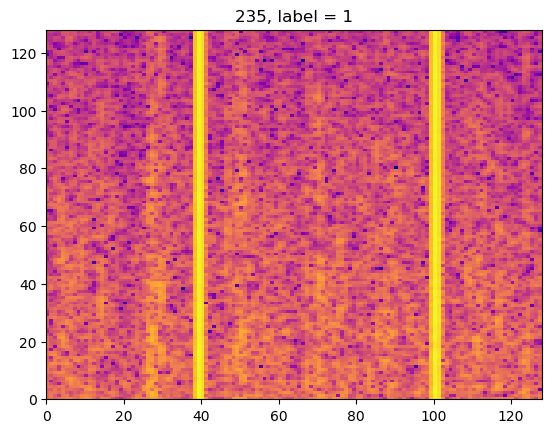

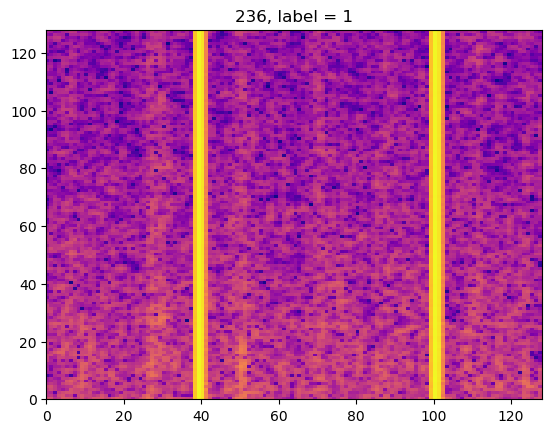

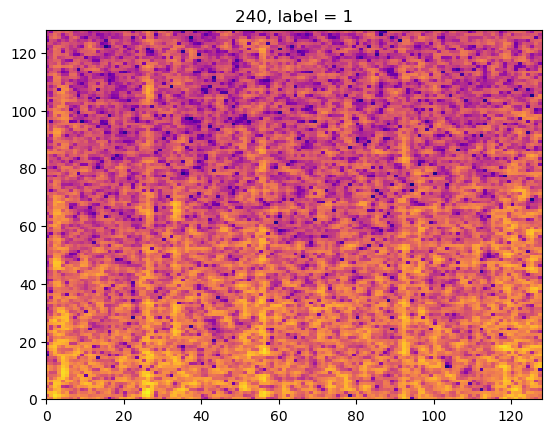

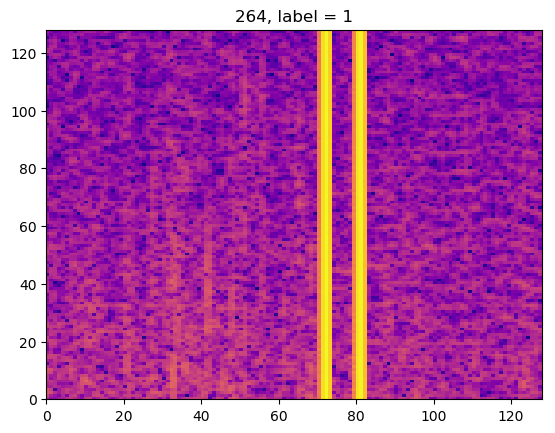

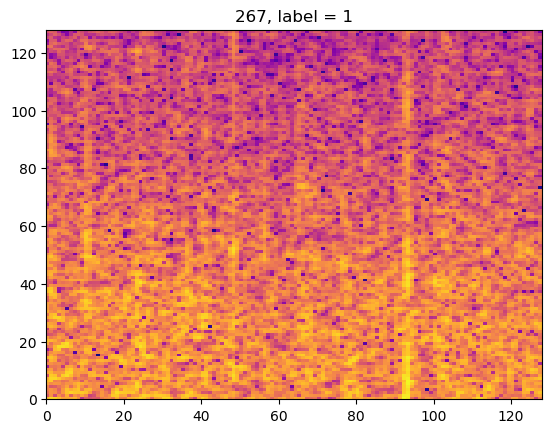

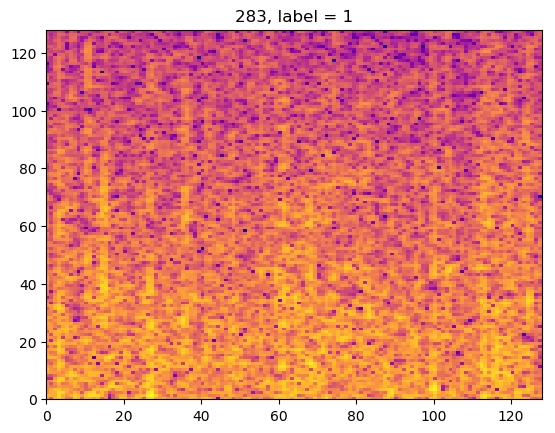

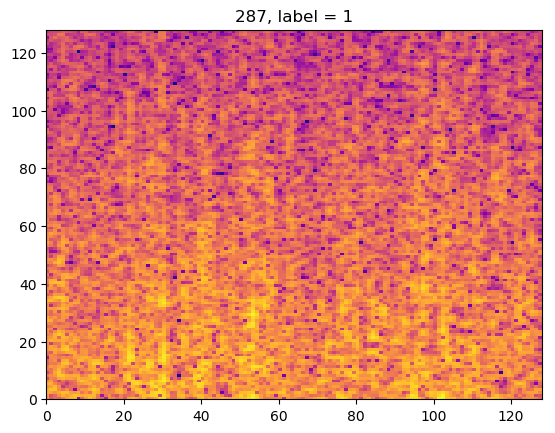

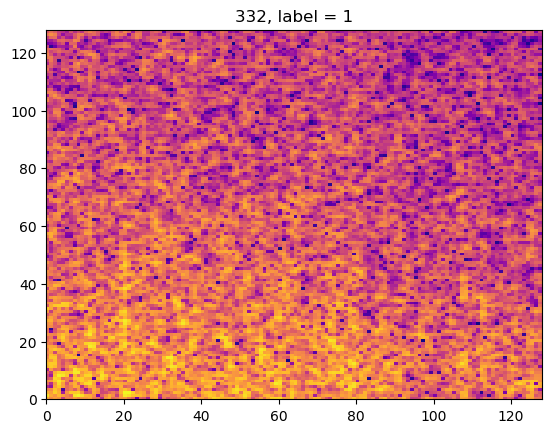

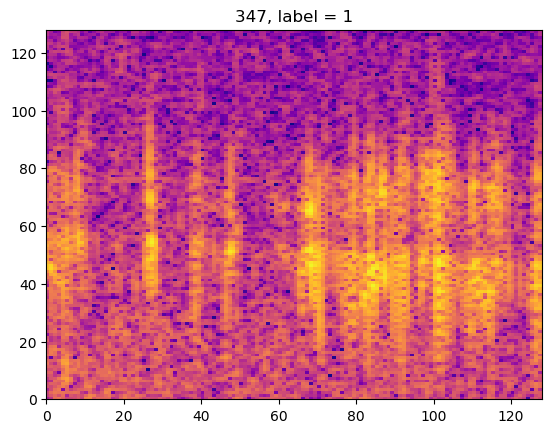

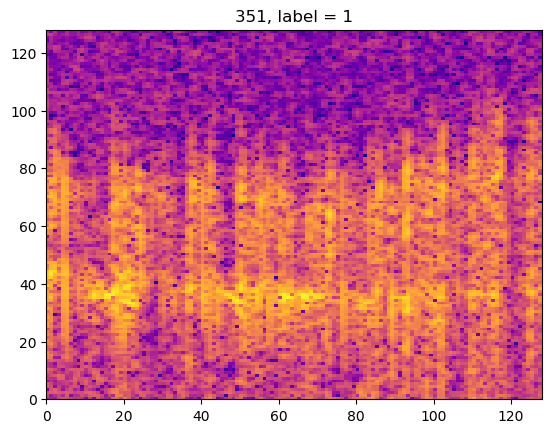

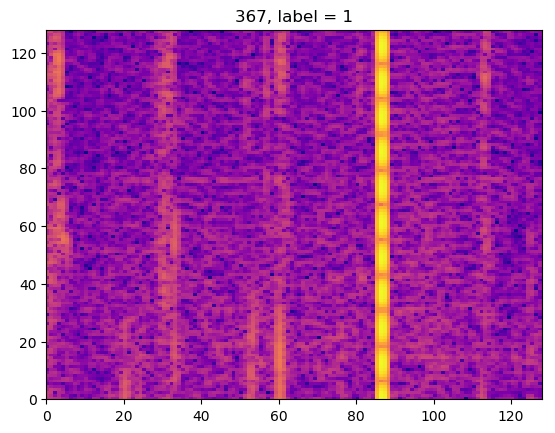

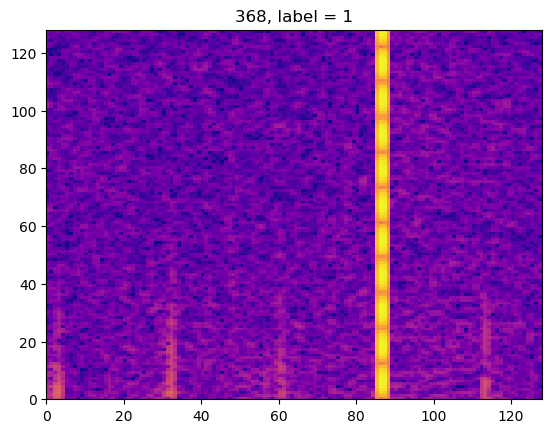

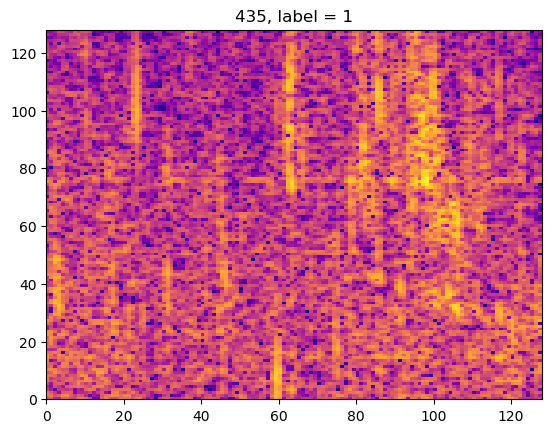

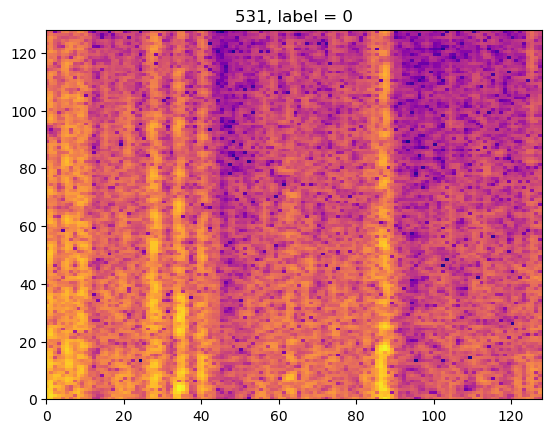

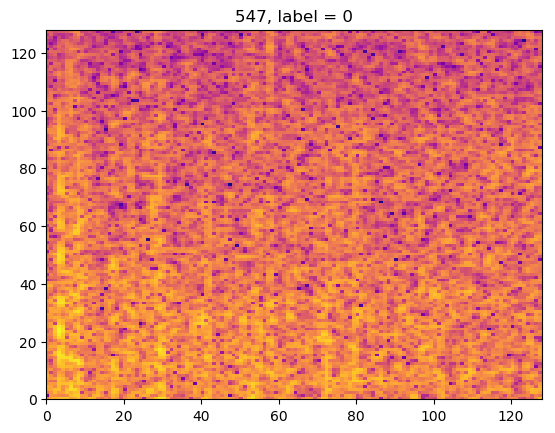

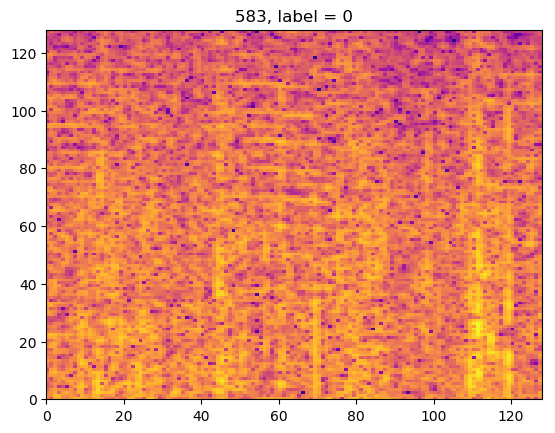

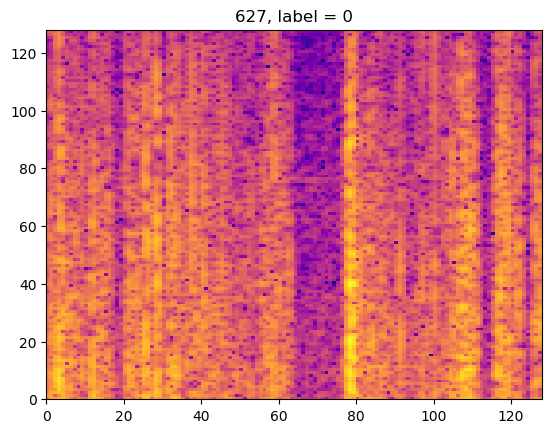

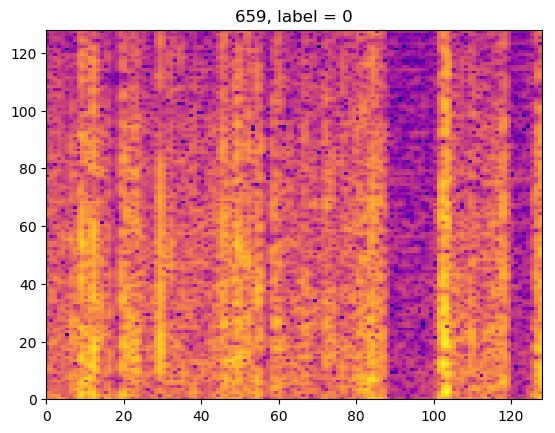

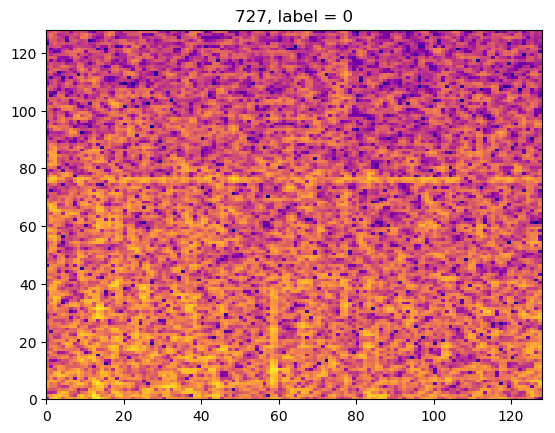

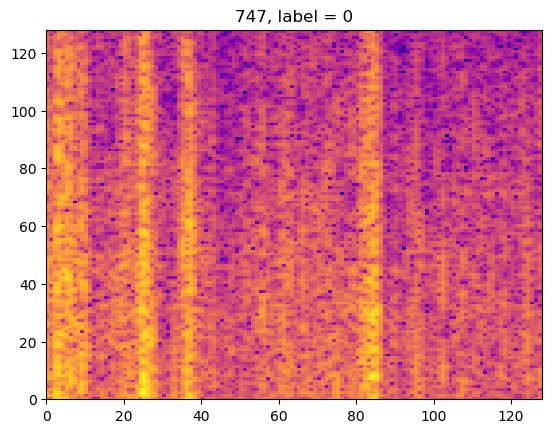

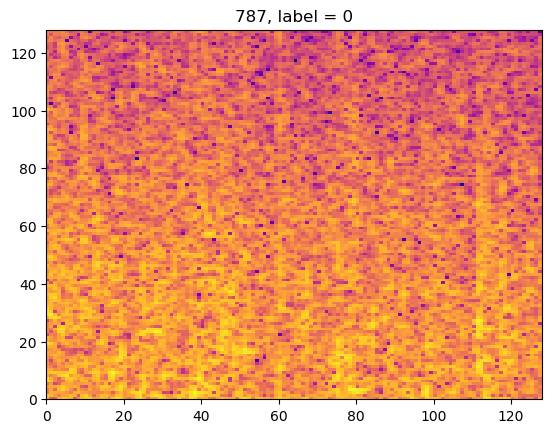

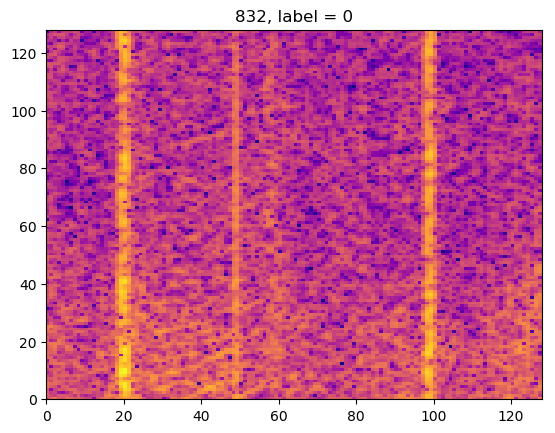

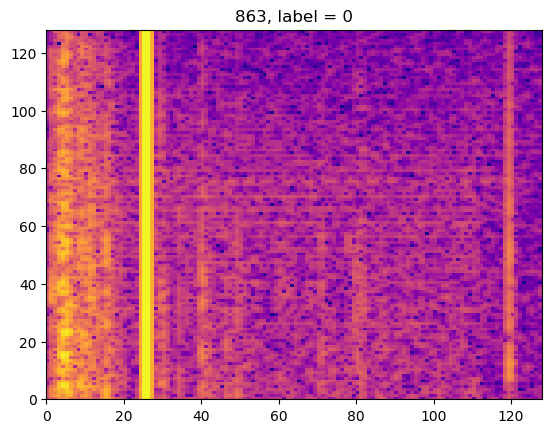

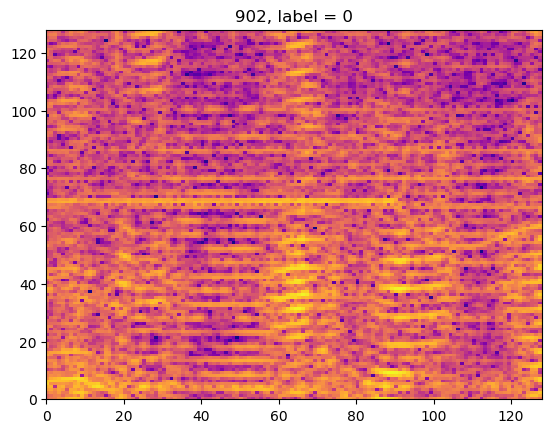

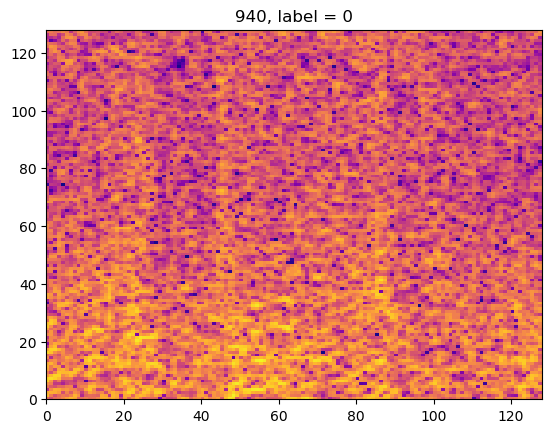

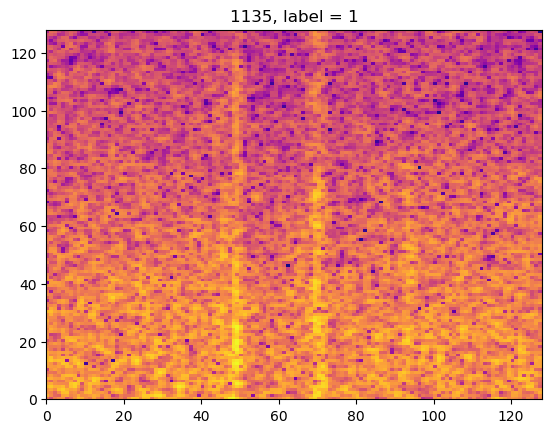

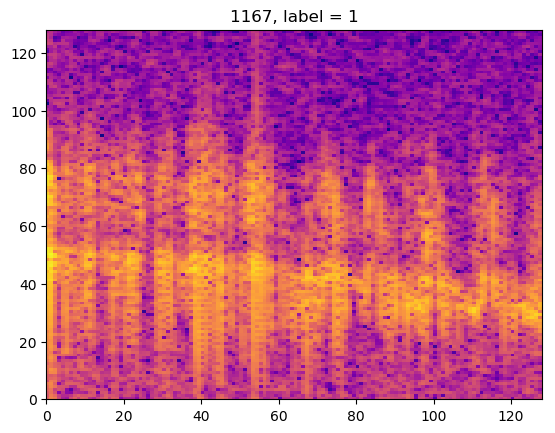

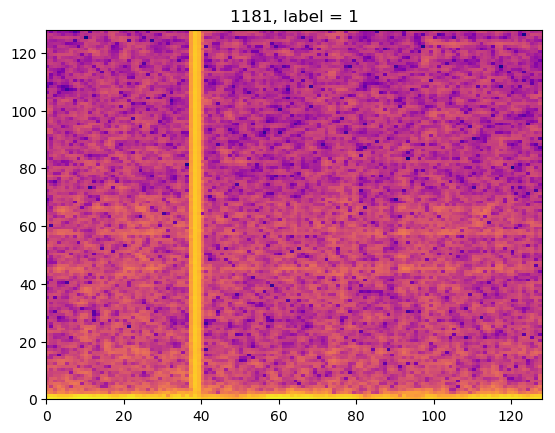

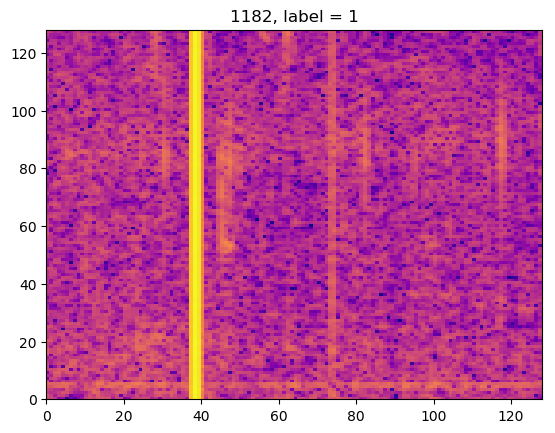

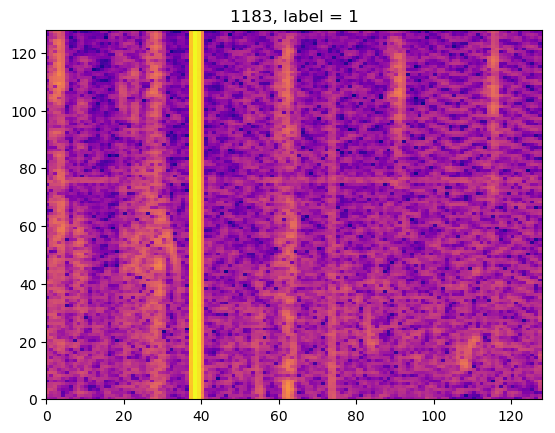

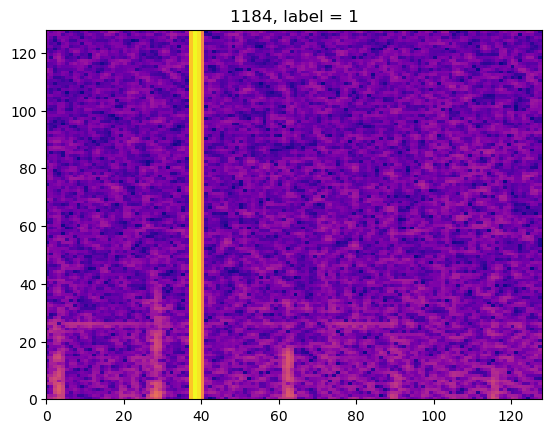

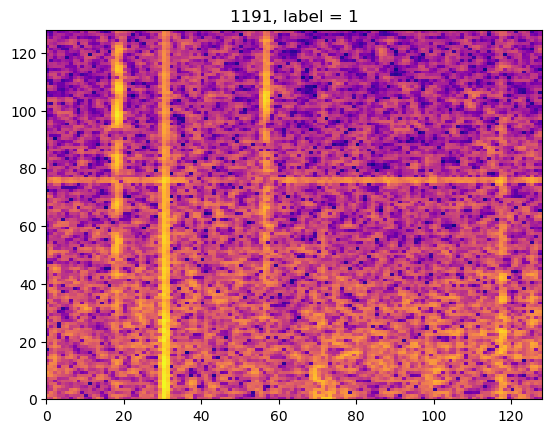

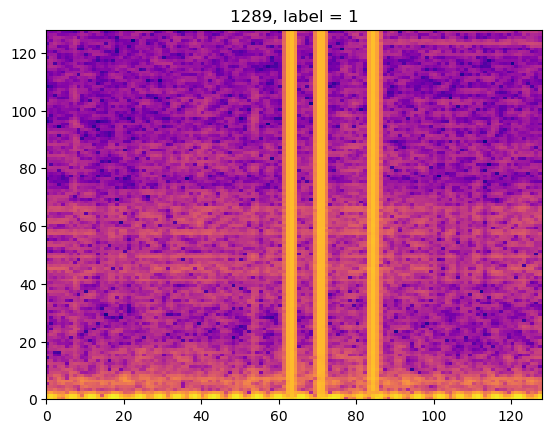

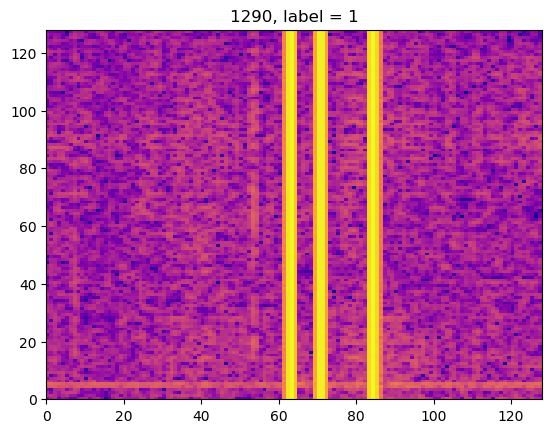

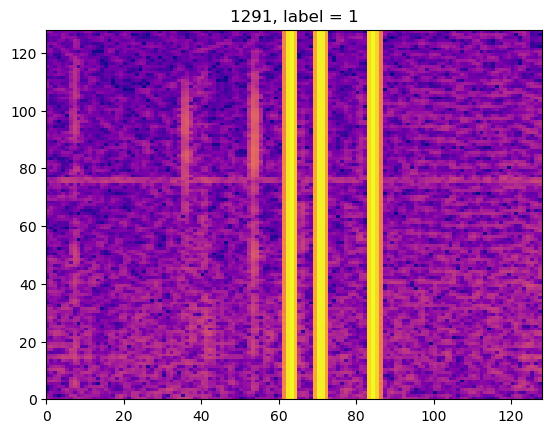

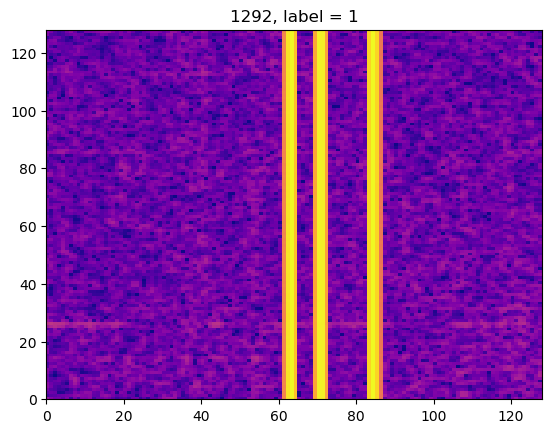

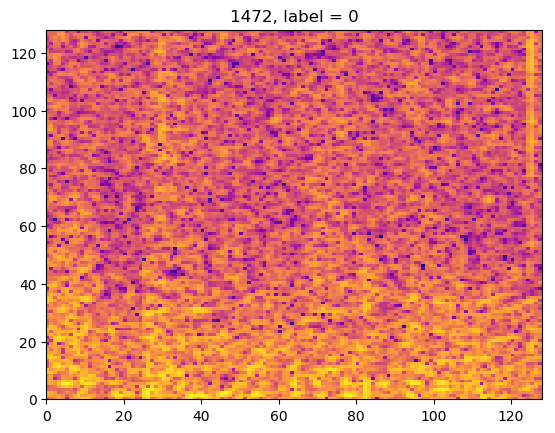

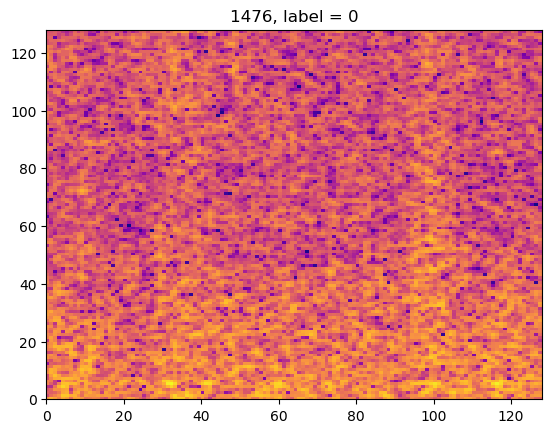

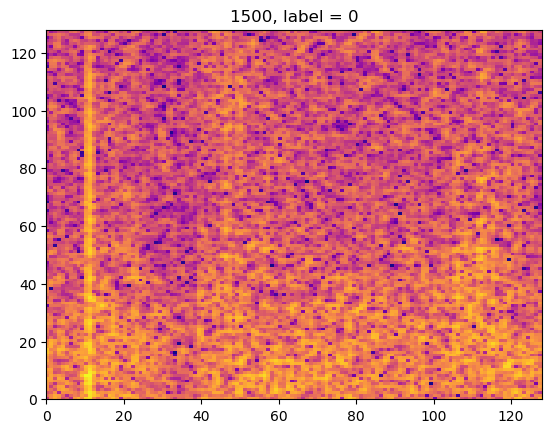

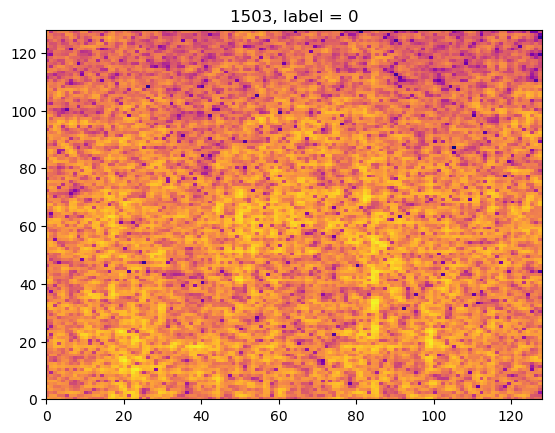

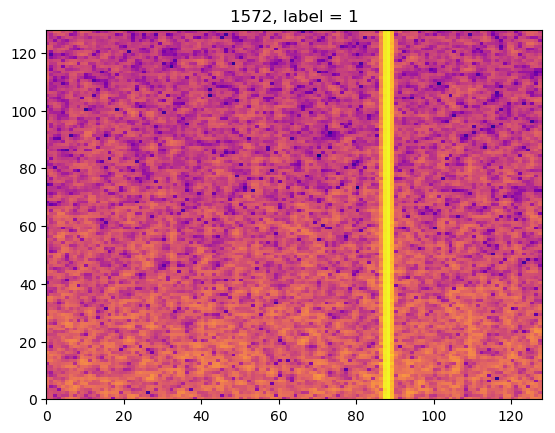

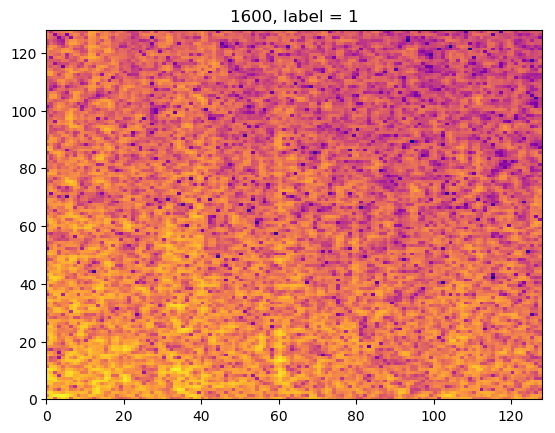

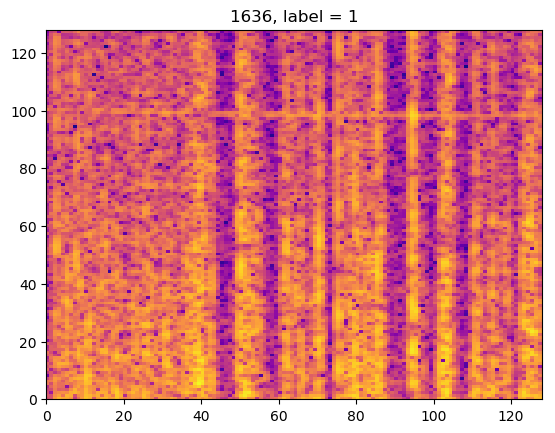

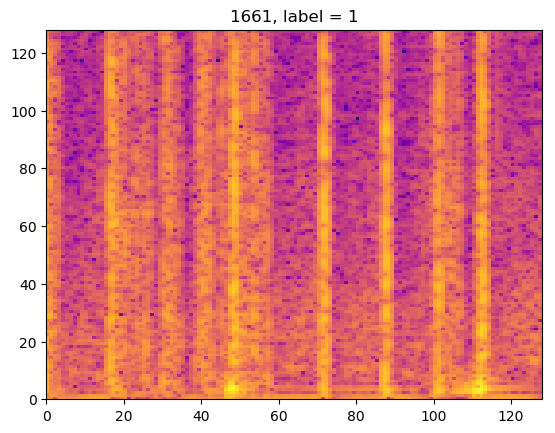

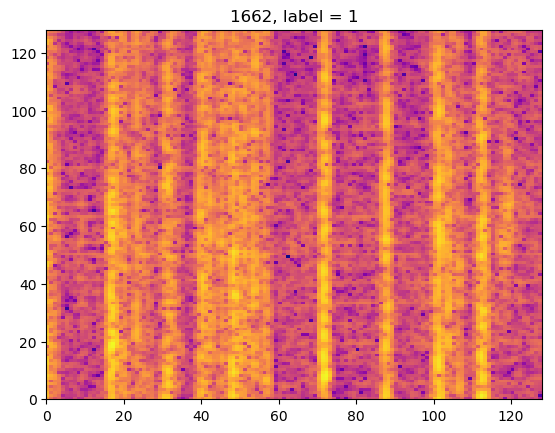

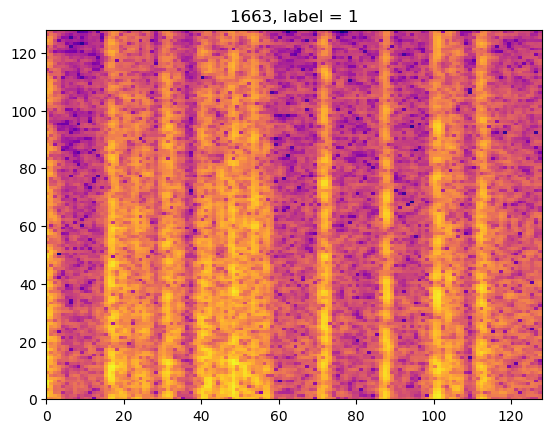

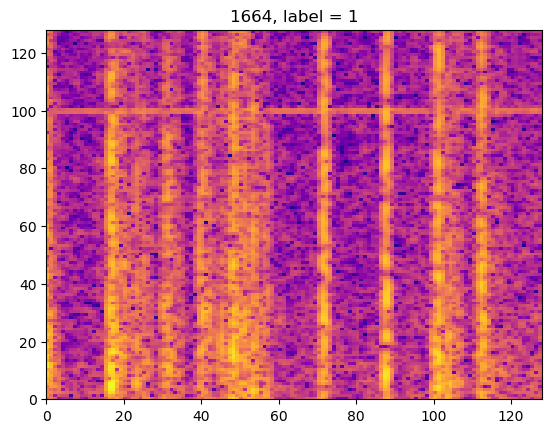

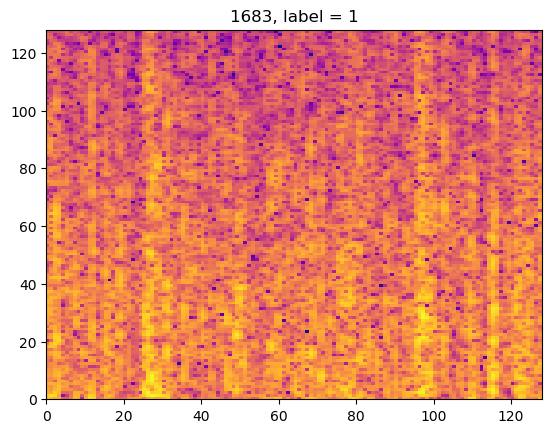

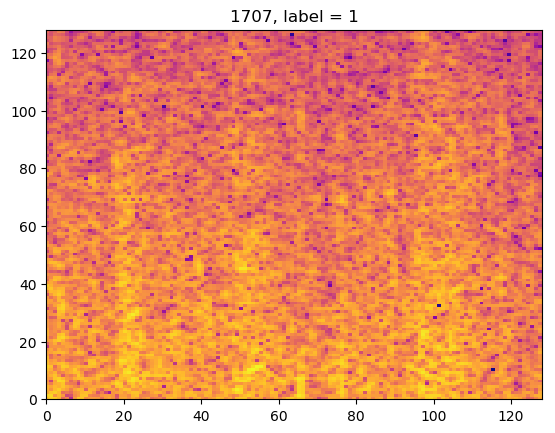

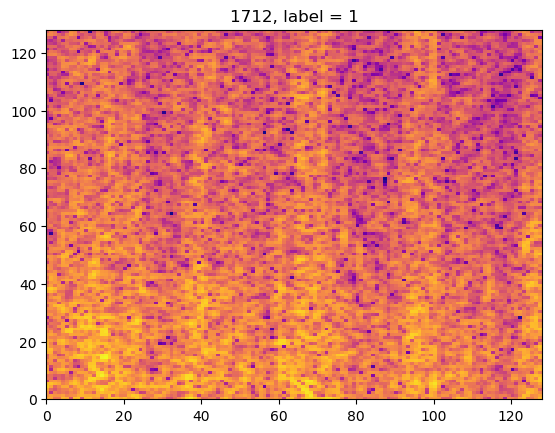

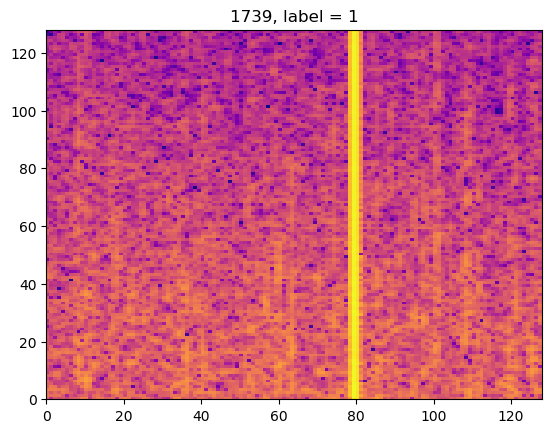

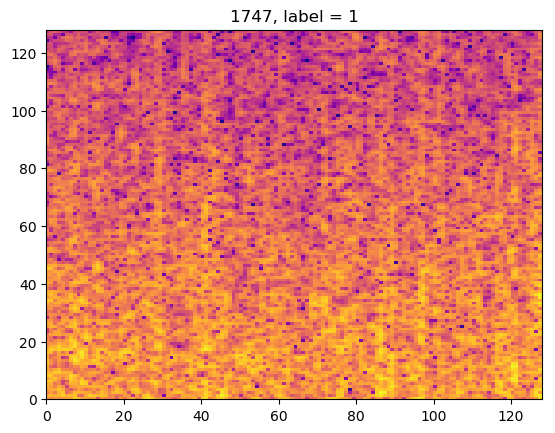

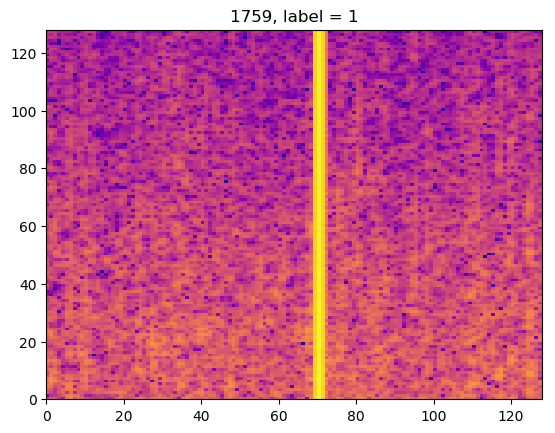

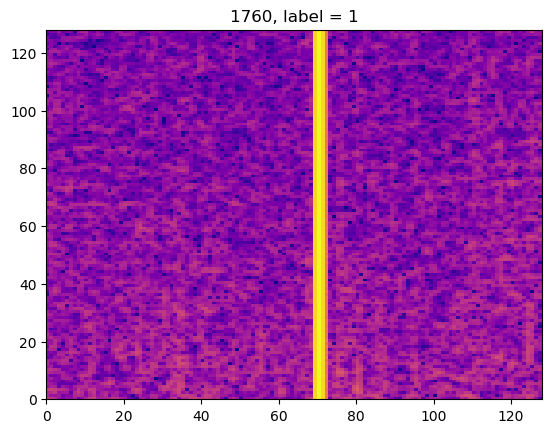

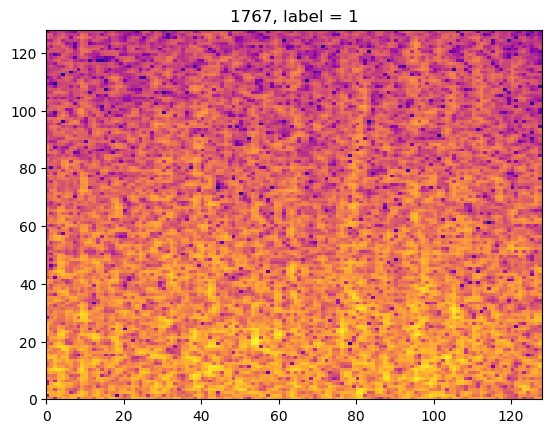

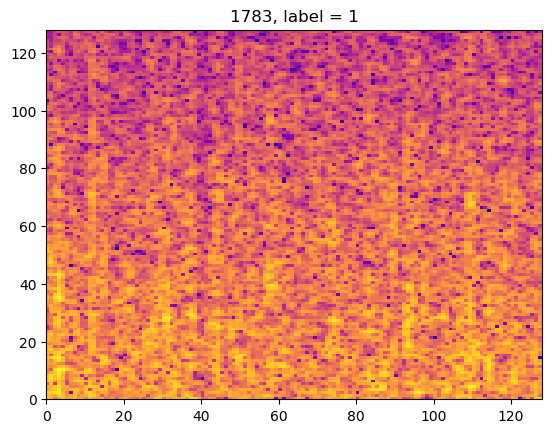

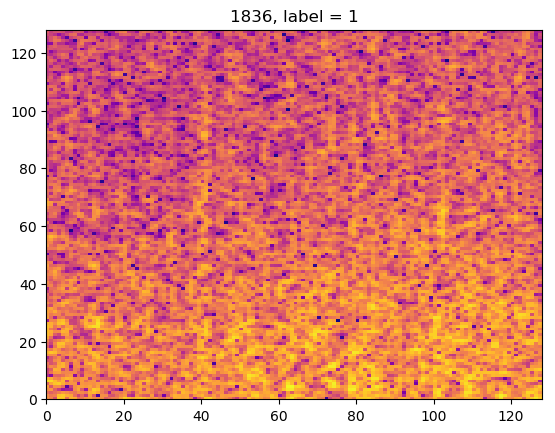

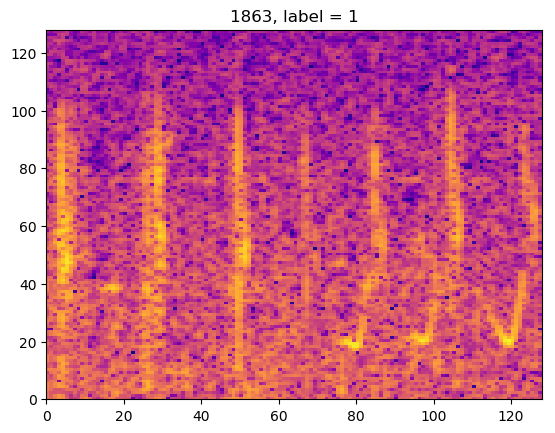

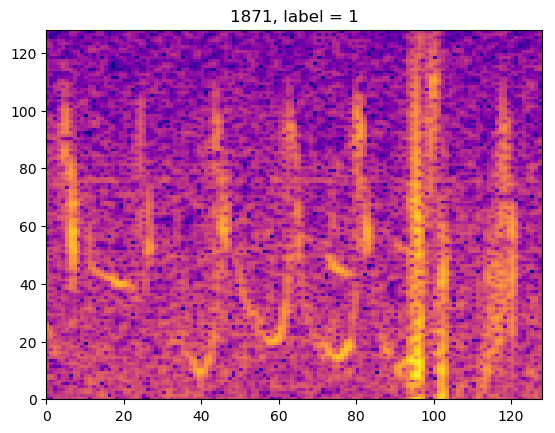

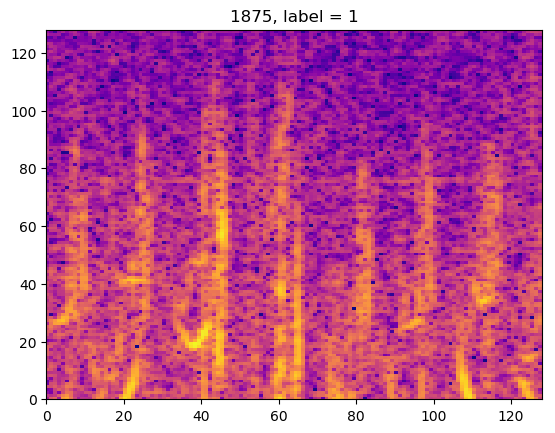

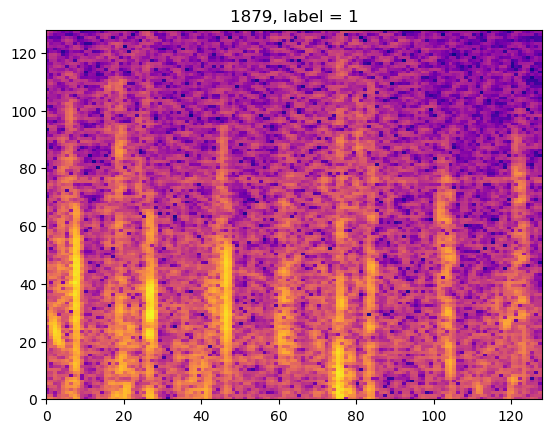

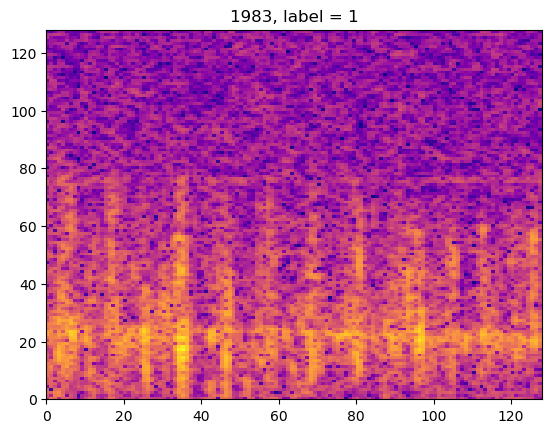

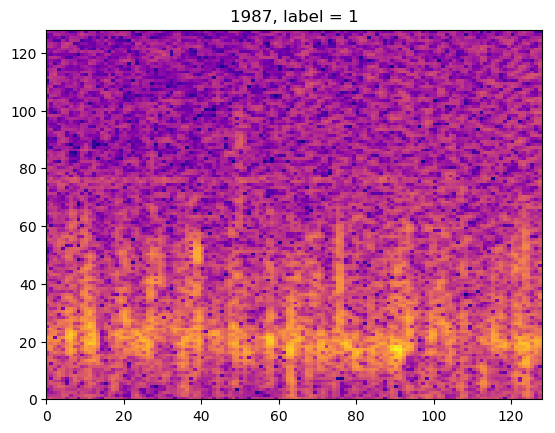

In [78]:
for i in clusterinds
    figure()
    pcolormesh(data[:,:,1,i], cmap="plasma")
    title("$i, label = $(data_labels[i])")
end

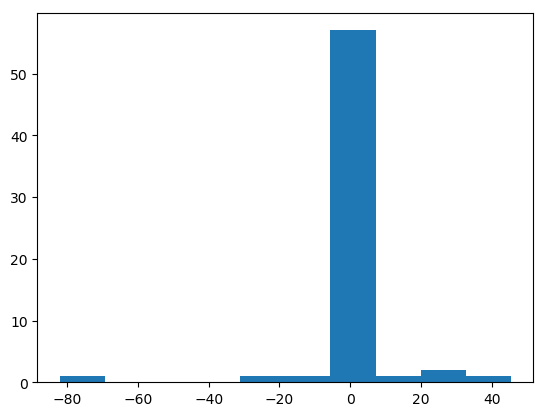

([1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 57.0, 1.0, 2.0, 1.0], Float32[-82.0549, -69.3076, -56.5602, -43.8128, -31.0655, -18.3181, -5.57073, 7.17664, 19.924, 32.6714, 45.4188], PyObject[PyObject <matplotlib.patches.Rectangle object at 0x7f06f8a10470>, PyObject <matplotlib.patches.Rectangle object at 0x7f06f89f1f60>, PyObject <matplotlib.patches.Rectangle object at 0x7f06f8a10a58>, PyObject <matplotlib.patches.Rectangle object at 0x7f06f8a10da0>, PyObject <matplotlib.patches.Rectangle object at 0x7f06f8a10eb8>, PyObject <matplotlib.patches.Rectangle object at 0x7f06f8a1e470>, PyObject <matplotlib.patches.Rectangle object at 0x7f06f8a1e7b8>, PyObject <matplotlib.patches.Rectangle object at 0x7f06f8a1eb00>, PyObject <matplotlib.patches.Rectangle object at 0x7f06f8a1ee48>, PyObject <matplotlib.patches.Rectangle object at 0x7f06f8a1ef60>])

In [99]:
plt.hist(mean(z,dims=2))

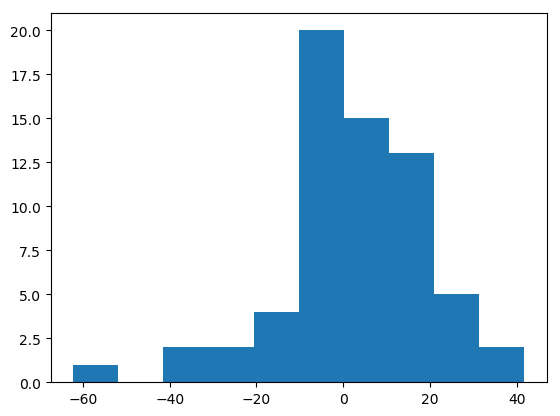

([1.0, 0.0, 2.0, 2.0, 4.0, 20.0, 15.0, 13.0, 5.0, 2.0], Float32[-62.227, -51.838, -41.4491, -31.0601, -20.6712, -10.2822, 0.106715, 10.4957, 20.8846, 31.2736, 41.6625], PyObject[PyObject <matplotlib.patches.Rectangle object at 0x7f06f8d75a58>, PyObject <matplotlib.patches.Rectangle object at 0x7f06f8d4d0f0>, PyObject <matplotlib.patches.Rectangle object at 0x7f06f8d75da0>, PyObject <matplotlib.patches.Rectangle object at 0x7f06f8d756a0>, PyObject <matplotlib.patches.Rectangle object at 0x7f06f8d759b0>, PyObject <matplotlib.patches.Rectangle object at 0x7f06f8d75898>, PyObject <matplotlib.patches.Rectangle object at 0x7f06f8d23b00>, PyObject <matplotlib.patches.Rectangle object at 0x7f06f8d23588>, PyObject <matplotlib.patches.Rectangle object at 0x7f06f8d23908>, PyObject <matplotlib.patches.Rectangle object at 0x7f06f8d237b8>])

In [100]:
plt.hist(mean(z[:,clusterinds],dims=2))

In [196]:
net = Flux.Chain(Dense(3,4), BatchNorm(4), Dense(4,3))
#net = Flux.Chain(Dense(3,4), Dense(4,3))
X = randn(Float32, 3,10)

3×10 Array{Float32,2}:
 -0.467474   1.17217    1.7299    …  -1.49686   0.970651  -0.770235
  0.594777   0.501091  -0.395722     -0.744791  0.105026  -1.04146 
 -0.341153  -0.334945  -0.790901      0.46695   0.879514  -0.872069

In [197]:
loss(X) = Flux.mse(X, net(X))
opt = ADAM(0.0001)
loss(X)

4.354062f0 (tracked)

In [198]:
for i in 1:10000
    l = loss(X)
    Flux.Tracker.back!(l)
    AlfvenDetectors.update!(net,opt)
end

In [199]:
loss(X)

1.3128228f-10 (tracked)

In [200]:
net(X)

Tracked 3×10 Array{Float32,2}:
 -0.467459   1.17215    1.72987   …  -1.49683   0.97065   -0.770235
  0.594778   0.501099  -0.395708     -0.744806  0.10502   -1.04145 
 -0.341152  -0.33495   -0.790911      0.46696   0.879517  -0.872071

In [206]:
Flux.testmode!(net,false)

Chain(Dense(3, 4), BatchNorm(4), Dense(4, 3))

In [224]:
mean(net.layers[2](net.layers[1](X)),dims=2)

Tracked 4×1 Array{Float32,2}:
 -0.04670311f0
 -0.06251322f0
  0.08171323f0
  0.13490015f0

In [223]:
net.layers[2](net.layers[1](X))

Tracked 4×10 Array{Float32,2}:
 -0.949041  -0.838679  0.278847   …   0.730682  -0.340603   1.09587 
 -1.62455   -0.657382  0.0608159      0.578782   1.41774   -0.573078
 -1.22839    0.448281  1.60555       -0.915491   0.902791  -0.323101
  0.491984   0.291356  0.661916      -0.252553  -0.933496   1.01588 

In [221]:
Flux.testmode!(net)

Chain(Dense(3, 4), BatchNorm(4), Dense(4, 3))

In [209]:
bn=(net.layers[2])

BatchNorm(4)

In [222]:
bn.active

false